In [1]:
# Reservoir Analysis for Bear Creek

In [4]:
from tqdm import tqdm

In [5]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

import pyproj as proj

In [23]:
# Physical Data
MG_to_cfs = 1.547 #cfs*day^-1/1e6 gallons*day^-1
seconds_in_day = 24*60*60
AF_to_ft3 = 43560 


DA_arcade = 332 #drainage area of Arcade (sq mi)
flow_pumpsite = 60.4 # non-depletable flow at pumpsite (cfs)
pump_capacity =  92.82 #cfs
DA_reservoir = 8.215234375 #sq mi
flow_reservoir_min = 4 #non-depletable flow out of reservoir (cfs)
SAE = pd.read_csv('BEAM_bearcreekSAE.csv')
#SAE['Cumulative Percentage of Volume'] = np.float_([str.strip(percent,'%') for percent in SAE['Cumulative Percentage of Volume']])
SAE_volume = SAE['Storage']
SAE_surfacearea = SAE['Area']
maximum_storage = max(SAE_volume)#np.float(MG_to_cfs*SAE[SAE['Cumulative Percentage of Volume']==100]['Reservoir Volume \n(MG)'])#maximum storage of reservoir, converted to cfs 
minimum_storage =  SAE.Storage[np.argmin(abs(SAE.Storage/MG_to_cfs-637))] #637 ft dead storage (BEAM)

arcade_flow=pd.read_csv('gage_streamflow_cfs.txt',sep='\t',skiprows=[0,1,2],names=['date','flow'])
l =  len(arcade_flow)
arcade_flow=pd.read_csv('gage_streamflow_cfs.txt',sep='\t',skiprows=[0,1,2],names=['date','flow'],parse_dates=True)
arcade_flow.drop(arcade_flow.tail(3).index,inplace=True)

In [39]:
minimum_storage

986.02

In [24]:
dates  = arcade_flow.date.astype(np.datetime64)

In [25]:
UIF = pd.read_csv('bearcreekreservoir_UIF_evap.txt',sep='\t', header=0, skiprows=[1,2],
                 names=['date','evap','stor','elev','totIn'])

In [26]:
UIF

,date,evap,stor,elev,totIn
0,01/01/1939,1.21,7552.05,350.39,2.96
1,01/02/1939,1.24,7552.05,350.39,5.24
2,01/03/1939,1.39,7552.05,350.39,5.39
3,01/04/1939,1.12,7552.05,350.39,5.12
4,01/05/1939,-11.97,7552.05,350.39,3.34
...,...,...,...,...,...
29215,12/27/2018,-6.15,7552.05,350.39,13.58
29216,12/28/2018,-12.62,7552.05,350.39,27.82
29217,12/29/2018,-0.09,7552.05,350.39,82.71
29218,12/30/2018,-5.17,7552.05,350.39,66.16


In [27]:
evap_rate = UIF['evap']

In [28]:
evap_rate[0]

1.21

In [29]:
flow_pumpsite_actual = [min(x,flow_pumpsite) for x in arcade_flow.flow] #timeseries of flow to pumpsite

In [30]:
pumped = [max(min(pump_capacity,x),0) for x in arcade_flow.flow-flow_pumpsite_actual] #timeseries of pumped water from available reservoir volume


In [31]:
flow_reservoir = arcade_flow.flow * DA_reservoir/DA_arcade   #timeseries of flow into reservoir (scaled by reservoir area/basin area

In [32]:
flow_surplus = flow_reservoir-[min(x,flow_reservoir_min) for x in flow_reservoir]

In [33]:
available = flow_surplus+pumped

available

0         96.020702
1         95.278362
2         95.253617
3         95.080405
4         96.961000
            ...    
29215    102.874979
29216    140.759087
29217    236.694219
29218    160.059939
29219    146.450364
Name: flow, Length: 29220, dtype: float64

In [48]:
n = 15 #how many guesses 

demand_ls = np.linspace(15,30,n)/MG_to_cfs #the range of guesses, converted from MG/day to cfs/day

storage = np.zeros([len(available),n])
storage[0,:] = maximum_storage

evaporation_ts = np.zeros([len(available),1])
SA_ts = np.zeros([len(available),1])
SA_U_ts = np.zeros([len(available),1])

In [51]:

for j in tqdm(np.arange(0,len(demand_ls))):
    demand = demand_ls[j]
    for i in np.arange(1,len(available)):
        index = np.argmin(np.abs(SAE_volume-storage[i-1,j]))
        #lower, upper bounds of reservoir volume at timestep i
        [vol_L, vol_U] = SAE_volume[index], SAE_volume[index+1]
        #lower, upper bounds of reservoir surface area at timestep i
        [SA_L, SA_U] = SAE_surfacearea[index],SAE_surfacearea[index+1]
        evap_loss = evap_rate.values[i]/seconds_in_day * (SA_L + (storage[i-1,j] - vol_L)/(vol_U-vol_L)*(SA_U-SA_L))
        demand_cfs = demand 
        storage_endofday = min(storage[i-1,j]-demand_cfs-evap_loss+available[i-1],maximum_storage)
        storage[i,j] = storage_endofday
        del index, vol_L, vol_U, SA_L, SA_U

100%|██████████| 15/15 [02:26<00:00,  9.79s/it]


Text(0.5, 0, 'Date')

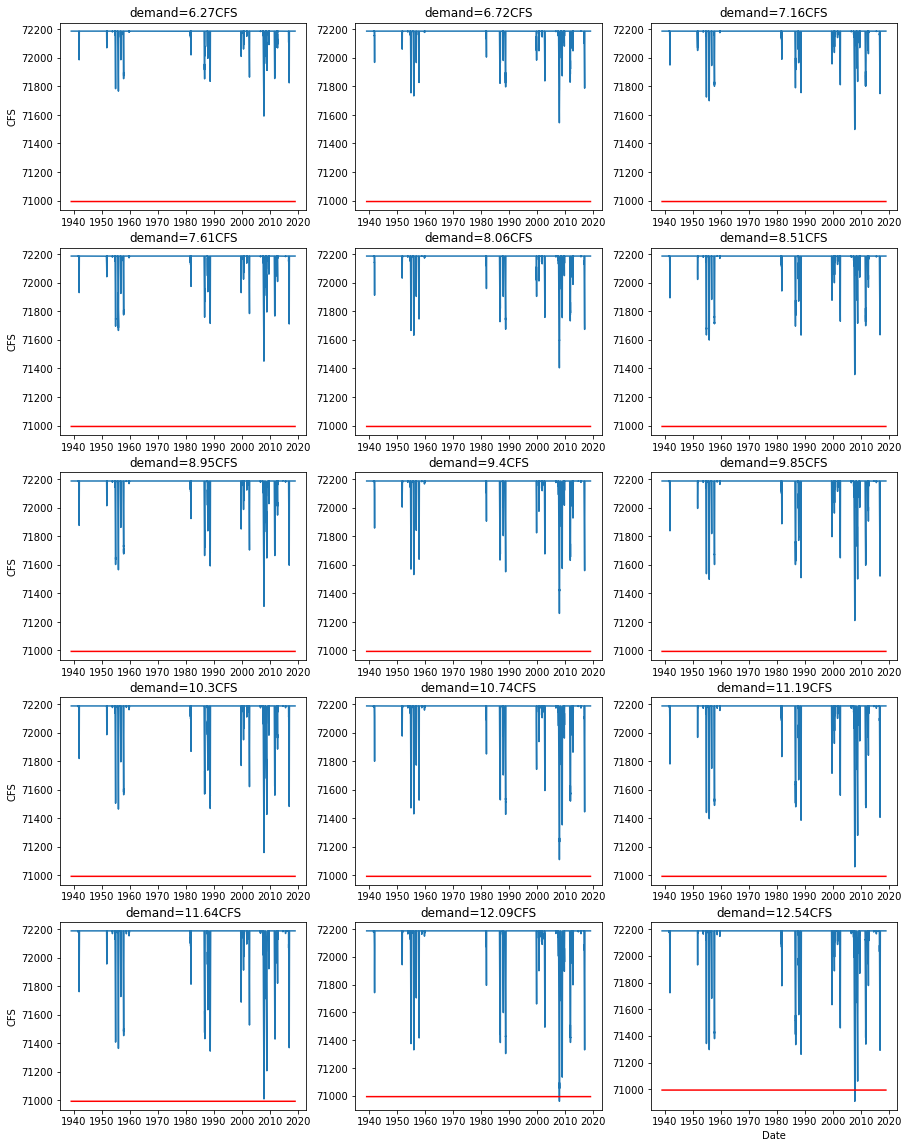

In [61]:
fig, ax = plt.subplots(ncols=int(n/5), nrows=int(n/3),figsize=[15,20])
[nc, nr] = ax.shape
count = 0
for i in np.arange(0,nc):
    for j in np.arange(0,nr):
        ax[i,j].plot(dates,storage[:,count]/MG_to_cfs)
        ax[i,j].plot(dates,minimum_storage*72*np.ones([len(arcade_flow.date),1]),'r')
        ax[i,j].set(title='demand='+str(np.round(demand_ls[count]/MG_to_cfs,2))+ 'CFS')
        if count%3==0:
            ax[i,j].set(ylabel='CFS')
        
        count = count+1


plt.xlabel('Date')

In [ ]:
plt.figure()
plt.plot(demand_ls,(np.min(storage,0)-minimum_storage),'.-')
plt.plot(demand_ls,np.zeros(demand_ls.shape),'r')

In [ ]:
index = np.argmin(abs(np.min(storage,0)-minimum_storage))
index

In [77]:
demand_ls

array([15.        , 16.07142857, 17.14285714, 18.21428571, 19.28571429,
       20.35714286, 21.42857143, 22.5       , 23.57142857, 24.64285714,
       25.71428571, 26.78571429, 27.85714286, 28.92857143, 30.        ])